In [1]:
import numpy as np
import matplotlib.pyplot as plt
import properscoring as ps
import pyreadr
from isodisreg import idr
import pandas as pd
from scipy.integrate import quad
import scipy as sc
from matplotlib.patches import Ellipse

In [2]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, (1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [3]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [4]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [5]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

In [6]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    #print(f"MAE: {np.round(mae,2)}")
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")
    
    #print(f"Bias: {np.round(bias,2)}")

In [7]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

In [8]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [9]:
test_predictions = np.load(result_path+f"cnn_interval_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
prediction = np.load(result_path+f"cnn_{model}_test.npy")[0]

test_samples = test_parameters.shape[0]

## Examples

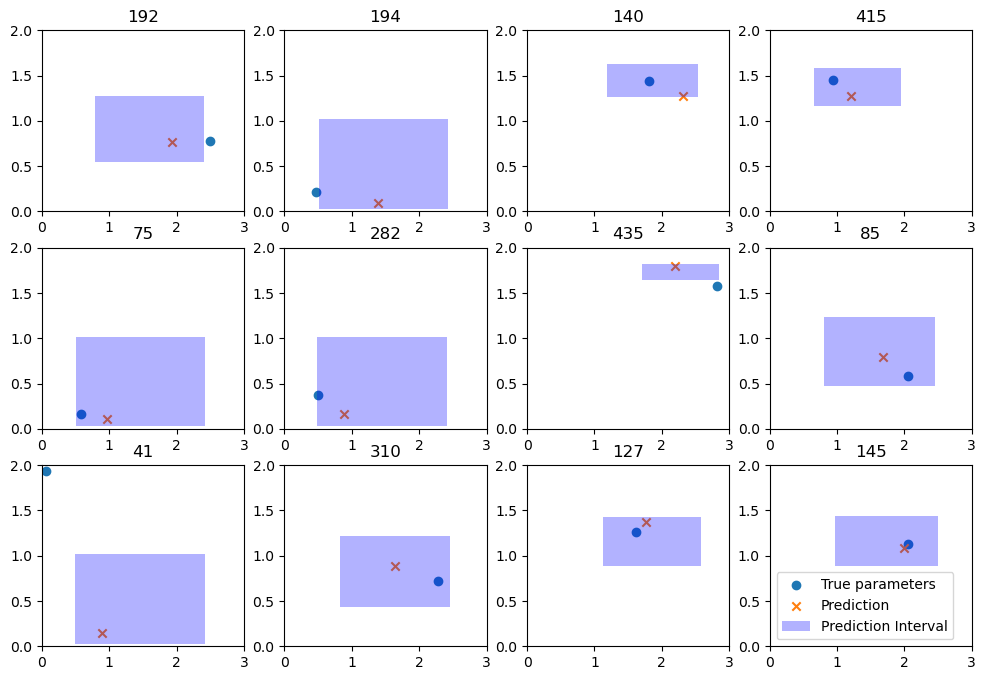

In [618]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(prediction[i,0], prediction[i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Computed scores and coverage

In [619]:
r_coverage = np.sum((test_parameters[:,0] >= test_predictions[0,:,0]) & ((test_parameters[:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= test_predictions[0,:,1]) & ((test_parameters[:,1] <= test_predictions[1,:,1])))/test_samples*100

In [620]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, test_predictions[0,:,0], test_predictions[1,:,0])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, test_predictions[0,:,1], test_predictions[1,:,1])
s_is = np.mean(s_is)

In [621]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 66.00%, 65.60% 
IS: 4.8515, 4.0544


# With quantile score

In [540]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [541]:
test_predictions = np.load(result_path+f"cnn_interval_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
prediction = np.load(result_path+f"cnn_{model}_test.npy")[0]

test_samples = test_parameters.shape[0]

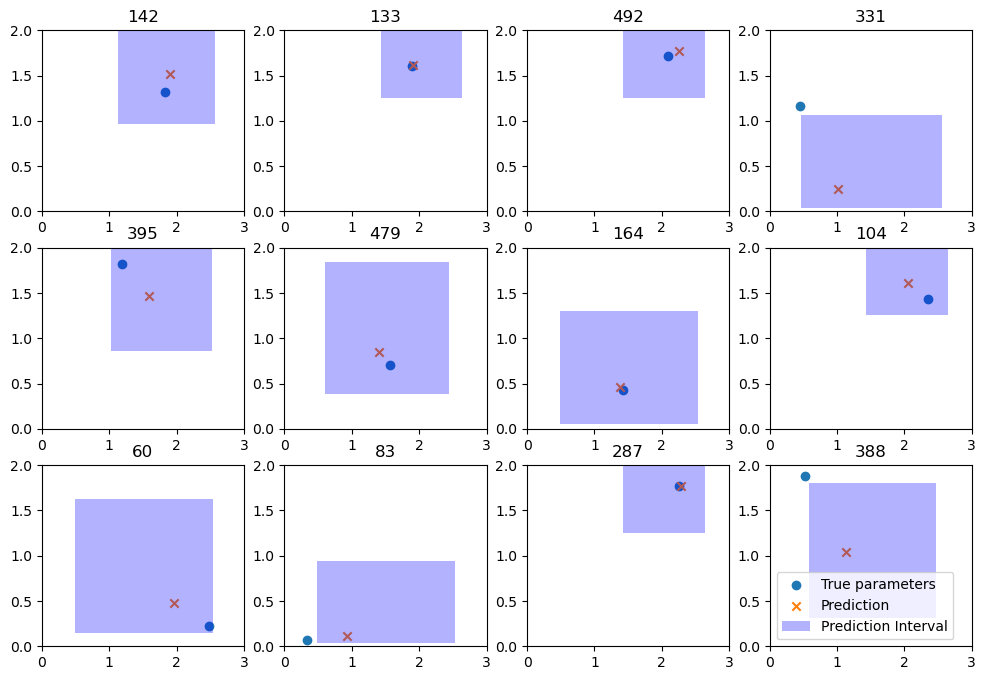

In [542]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(prediction[i,0], prediction[i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Computed scores and coverage

In [543]:
r_coverage = np.sum((test_parameters[:,0] >= test_predictions[0,:,0]) & ((test_parameters[:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= test_predictions[0,:,1]) & ((test_parameters[:,1] <= test_predictions[1,:,1])))/test_samples*100

In [544]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, test_predictions[0,:,0], test_predictions[1,:,0])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, test_predictions[0,:,1], test_predictions[1,:,1])
s_is = np.mean(s_is)

In [545]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 66.20%, 80.80% 
IS: 4.7764, 3.5926


# Evaluate Mean and Interval prediction together

In [228]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "brown"

In [229]:
test_predictions = np.load(result_path+f"cnn_interval_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]

test_samples = test_parameters.shape[0]

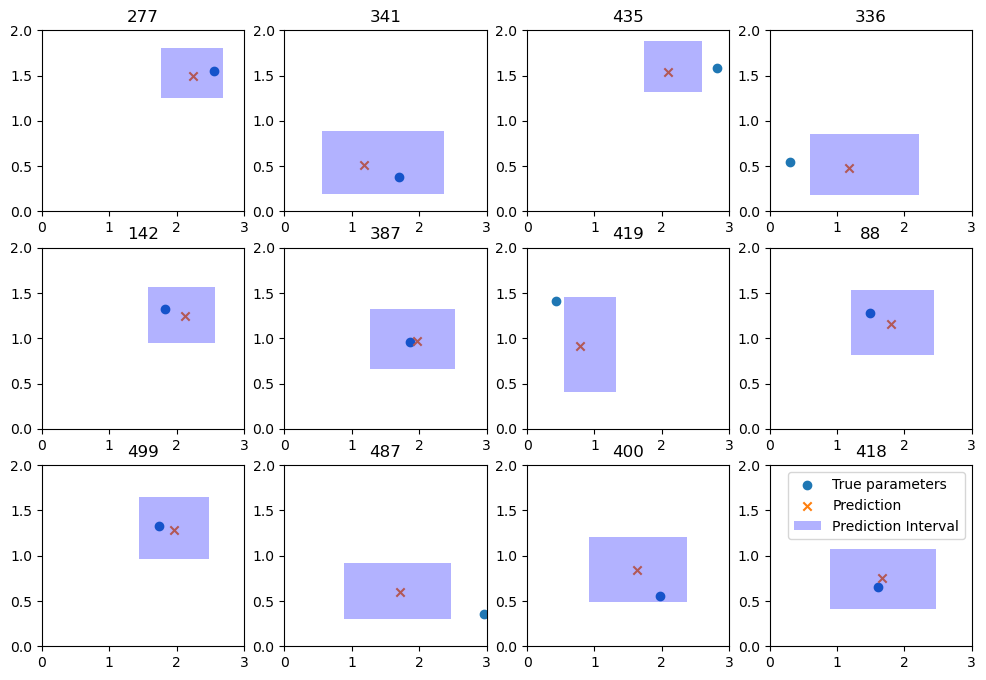

In [230]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[2,i,0], test_predictions[2,i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Computed scores and coverage

In [231]:
r_coverage = np.sum((test_parameters[:,0] >= test_predictions[0,:,0]) & ((test_parameters[:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= test_predictions[0,:,1]) & ((test_parameters[:,1] <= test_predictions[1,:,1])))/test_samples*100

In [232]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, test_predictions[0,:,0], test_predictions[1,:,0])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, test_predictions[0,:,1], test_predictions[1,:,1])
s_is = np.mean(s_is)

In [233]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: brown
Coverage 64.40%, 92.00% 
IS: 4.7225, 1.4466


## Coverage of mean prediction

In [234]:
r_coverage = np.sum((test_predictions[2,:,0] >= test_predictions[0,:,0]) & ((test_predictions[2,:,0] <= test_predictions[1,:,0])))/test_samples*100
s_coverage = np.sum((test_predictions[2,:,1] >= test_predictions[0,:,1]) & ((test_predictions[2,:,1] <= test_predictions[1,:,1])))/test_samples*100
print(f"Model: {model}\nPrediction Coverage {r_coverage:.2f}%, {s_coverage:.2f}%")

Model: brown
Prediction Coverage 100.00%, 100.00%


## Mean prediction

In [235]:
get_metrics(test_predictions[2], test_parameters, model)

RMSE: [0.56 0.28]
Ext - IMSE: 0.3426


# Evalute CRPS Normal prediction

In [467]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "brown"

In [468]:
test_predictions = np.load(result_path+f"cnn_crps_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]

test_samples = test_parameters.shape[0]

## Computed scores and coverage

In [469]:
norm = sc.stats.norm(loc = test_predictions[0], scale = test_predictions[1])
r_lower = norm.ppf(0.025)[:,0]
s_lower = norm.ppf(0.025)[:,1]
r_upper = norm.ppf(0.975)[:,0]
s_upper = norm.ppf(0.975)[:,1]

In [470]:
r_coverage = np.sum((test_parameters[:,0] >= r_lower) & ((test_parameters[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= s_lower) & ((test_parameters[:,1] <= s_upper)))/test_samples*100

In [471]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, s_lower, s_upper)
s_is = np.mean(s_is)

In [472]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: brown
Coverage 74.20%, 87.80% 
IS: 3.0453, 1.6236


## Mean prediction

In [473]:
get_metrics(test_predictions[0], test_parameters, model)

RMSE: [0.48 0.28]
Ext - IMSE: 0.3073


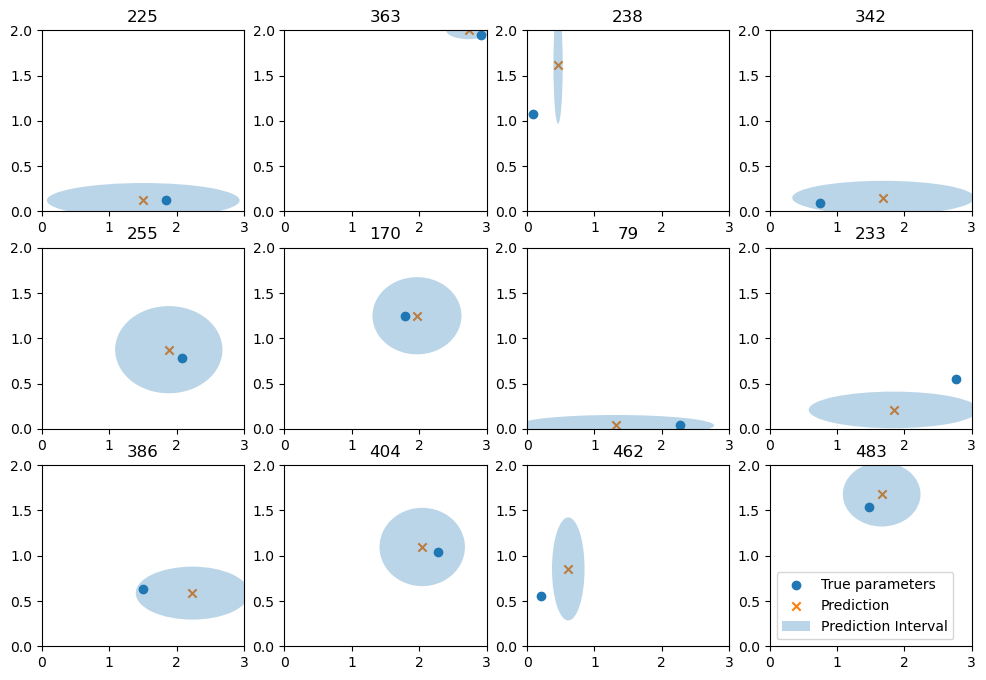

In [474]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[0,i,0], test_predictions[0,i,1], marker = "x", label = "Prediction")
    
    cutoff = np.sqrt(sc.stats.chi2(df = 2).ppf(0.95))
    center = test_predictions[0,i]
    axis = 2*test_predictions[1,i]*cutoff
    ellipse = Ellipse(center, width = axis[0], height = axis[1], alpha = 0.3)
    
    axs[x].add_patch(ellipse)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

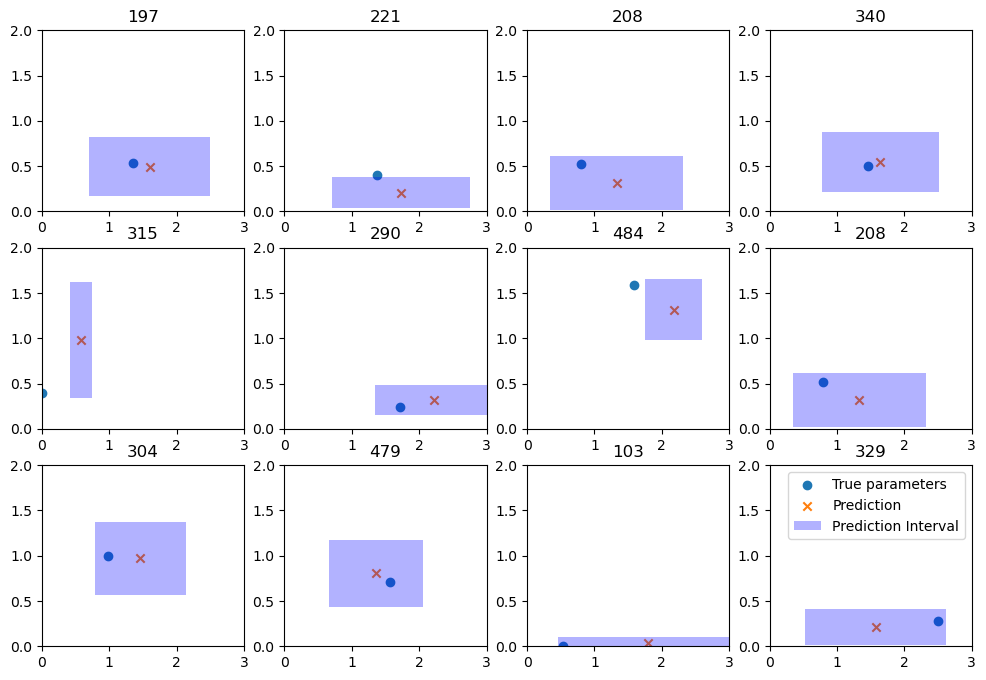

In [475]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[0,i,0], test_predictions[0,i,1], marker = "x", label = "Prediction")
    
    anchor = (r_lower[i], s_lower[i])
    rectangle = plt.Rectangle(anchor, (r_upper[i]-r_lower[i]), (s_upper[i]-s_lower[i]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

# Evalute CRPS Truncated Normal prediction

In [190]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [191]:
test_predictions = np.load(result_path+f"cnn_crps_trunc_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
test_samples = test_parameters.shape[0]

## Computed scores and coverage

In [192]:
a = (0 - test_predictions[0,:,:]) / test_predictions[1,:,:]
b = (np.inf - test_predictions[0,:,:]) / test_predictions[1,:,:]
trunc_norm = sc.stats.truncnorm(a,b, loc = test_predictions[0,:,:], scale = test_predictions[1,:,:])
r_lower = trunc_norm.ppf(0.025)[:,0]
s_lower = trunc_norm.ppf(0.025)[:,1]
r_upper = trunc_norm.ppf(0.975)[:,0]
s_upper = trunc_norm.ppf(0.975)[:,1]

In [193]:
r_coverage = np.sum((test_parameters[:,0] >= r_lower) & ((test_parameters[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= s_lower) & ((test_parameters[:,1] <= s_upper)))/test_samples*100

In [194]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, s_lower, s_upper)
s_is = np.mean(s_is)

In [195]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 82.20%, 84.60% 
IS: 3.0628, 4.2256


## Mean prediction

In [196]:
get_metrics(test_predictions[0], test_parameters, model)

RMSE: [0.63 0.5 ]
Ext - IMSE: 0.01


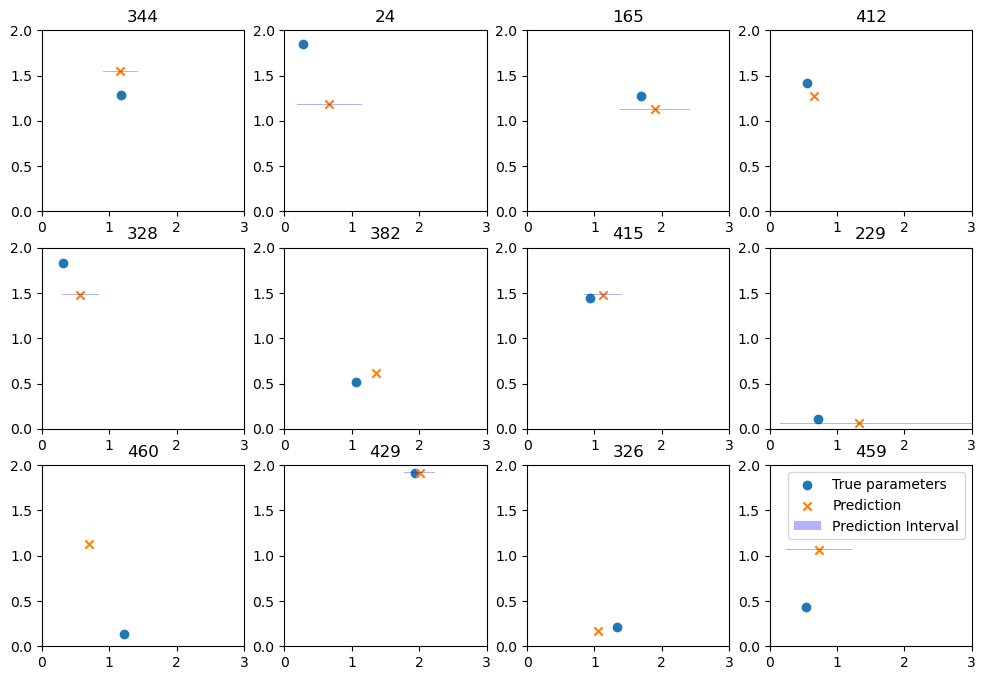

In [187]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[0,i,0], test_predictions[0,i,1], marker = "x", label = "Prediction")
    
    anchor = (r_lower[i], s_lower[i])
    rectangle = plt.Rectangle(anchor, (r_upper[i]-r_lower[i]), (s_upper[i]-s_lower[i]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

# Evalute Combined CRPS Normal and Truncated

In [83]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

In [84]:
test_predictions = np.load(result_path+f"cnn_crps_trunc_{model}_test.npy")
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]
test_samples = test_parameters.shape[0]

## Computed scores and coverage

In [85]:
a = (0 - test_predictions[0,:,:]) / test_predictions[1,:,:]
b = (np.inf - test_predictions[0,:,:]) / test_predictions[1,:,:]
trunc_norm = sc.stats.truncnorm(a,b, loc = test_predictions[0,:,:], scale = test_predictions[1,:,:])
norm = sc.stats.norm(loc = test_predictions[0], scale = test_predictions[1])
r_lower = norm.ppf(0.025)[:,0]
r_upper = norm.ppf(0.975)[:,0]
s_lower = trunc_norm.ppf(0.025)[:,1]
s_upper = trunc_norm.ppf(0.975)[:,1]

In [86]:
r_coverage = np.sum((test_parameters[:,0] >= r_lower) & ((test_parameters[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= s_lower) & ((test_parameters[:,1] <= s_upper)))/test_samples*100

In [87]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, s_lower, s_upper)
s_is = np.mean(s_is)

In [88]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 89.80%, 79.80% 
IS: 2.5909, 5.4011


## Mean prediction

In [89]:
get_metrics(test_predictions[0], test_parameters, model)

RMSE: [0.6  0.51]
Ext - IMSE: 0.0088


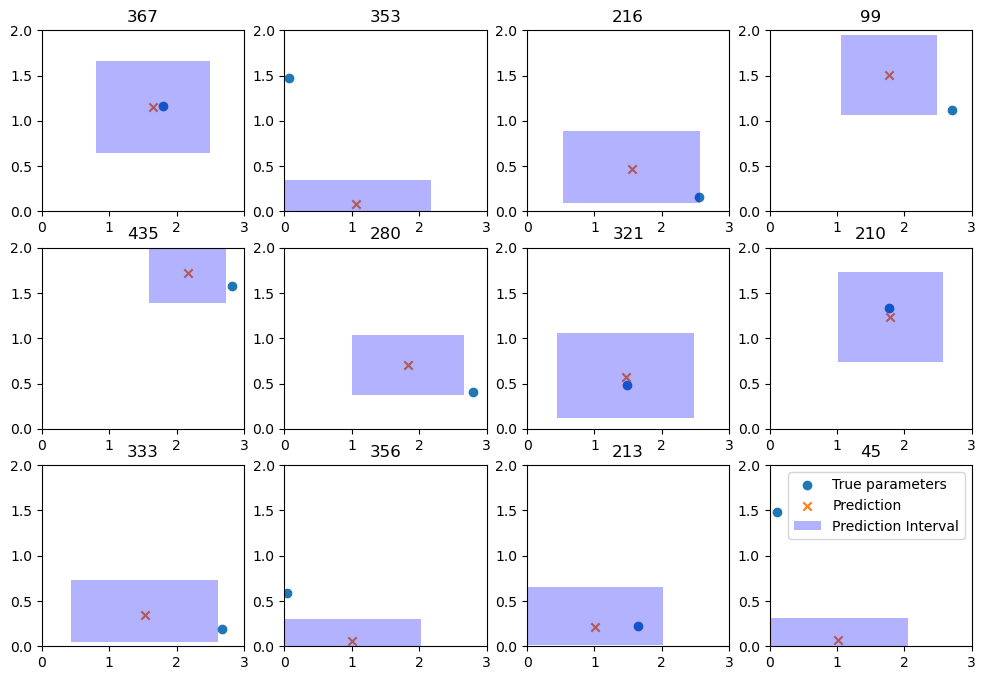

In [90]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[0,i,0], test_predictions[0,i,1], marker = "x", label = "Prediction")
    
    anchor = (r_lower[i], s_lower[i])
    rectangle = plt.Rectangle(anchor, (r_upper[i]-r_lower[i]), (s_upper[i]-s_lower[i]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])